<a href="https://colab.research.google.com/github/srimanthtenneti/Autoencoders/blob/main/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as f

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
data_transform = transforms.ToTensor()

In [ ]:
dataset = torchvision.datasets.MNIST('./root',download=True,transform = data_transform,train=True)
testset = torchvision.datasets.MNIST('./root',download=True,transform = data_transform,train=False)

In [ ]:
batch_size = 20
num_workers = 0

In [ ]:
trainloader = DataLoader(dataset , shuffle = True , batch_size = batch_size , num_workers = num_workers)
testloader  = DataLoader(testset , shuffle = True , batch_size = batch_size , num_workers = num_workers)

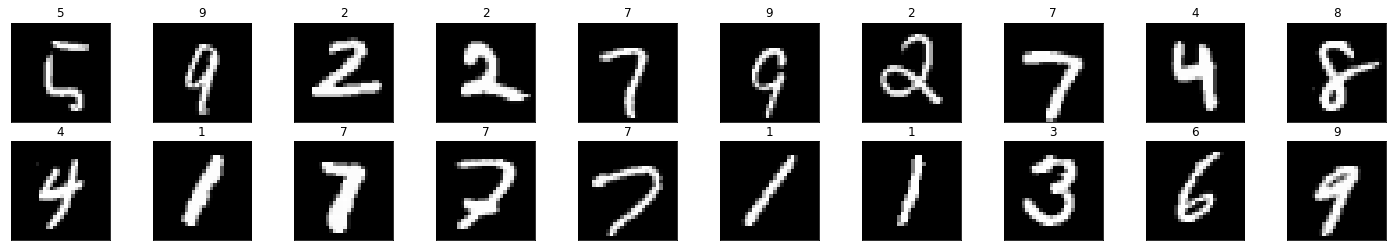

In [ ]:
images , labels = iter(trainloader).next()
images = images.numpy()

fig = plt.figure(figsize = (25,4))

for i in range(batch_size):
  ax = fig.add_subplot(2 , batch_size / 2 , i+1 , xticks = [] , yticks = [])
  ax.imshow(np.squeeze(images[i]) , cmap = 'gray')
  ax.set_title(labels[i].item())

(20, 1, 28, 28)

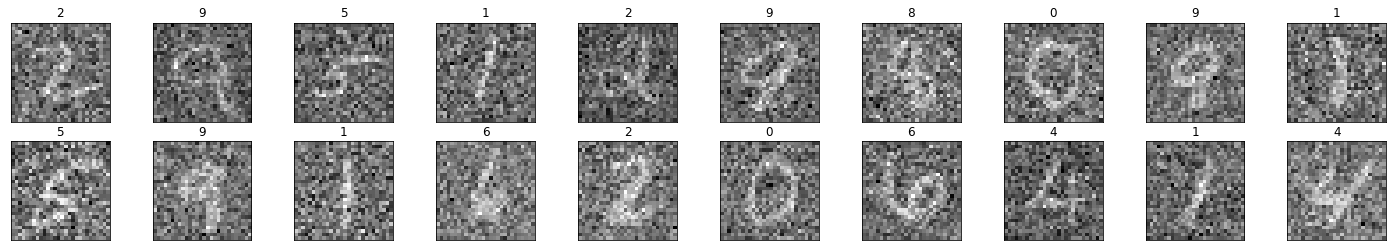

In [ ]:
images , labels = iter(trainloader).next()
images = images.numpy()

noise_factor = 0.5

fig = plt.figure(figsize = (25,4))

for i in range(batch_size):
  images_n = images[i] + np.random.randn(*images[i].shape) * noise_factor
  ax = fig.add_subplot(2 , batch_size / 2 , i+1 , xticks = [] , yticks = [])
  ax.imshow(np.squeeze(images_n) , cmap = 'gray')
  ax.set_title(labels[i].item())

images.shape

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x

# initialize the NN
model = ConvDenoiser()
model.cuda()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
# specify loss function
criterion = nn.MSELoss().cuda()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
noise_factor = 0.5
n_epochs = 10
trainloss = []

for epoch in range(n_epochs):
  train_loss = 0.0
  for batch_i , (images , target) in enumerate(trainloader):
    noisy_images = images + torch.randn(*images.shape) * noise_factor
    noisy_images = torch.tensor(noisy_images).cuda()
    optimizer.zero_grad()
    output = model(noisy_images)
    loss = criterion(output , images.cuda())
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    
  print("Epoch: {} , Batch: {} , Training Loss: {}".format(epoch + 1 , batch_i + 1 , train_loss / len(trainloader)))
  trainloss.append(train_loss / len(trainloader))

print("Training Completed !!!")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 , Batch: 3000 , Training Loss: 0.04062291458187004
Epoch: 2 , Batch: 3000 , Training Loss: 0.02855042537363867
Epoch: 3 , Batch: 3000 , Training Loss: 0.026645361721515656
Epoch: 4 , Batch: 3000 , Training Loss: 0.02554143006540835
Epoch: 5 , Batch: 3000 , Training Loss: 0.024760463405400515
Epoch: 6 , Batch: 3000 , Training Loss: 0.02409604871397217
Epoch: 7 , Batch: 3000 , Training Loss: 0.023529019298031927
Epoch: 8 , Batch: 3000 , Training Loss: 0.023168280726919573
Epoch: 9 , Batch: 3000 , Training Loss: 0.022883720071365438
Epoch: 10 , Batch: 3000 , Training Loss: 0.022641548275016247
Training Completed !!!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


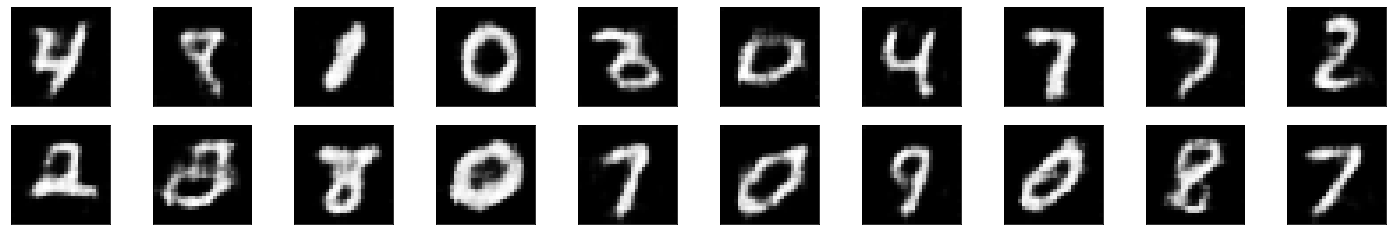

In [ ]:
images , labels = iter(testloader).next()
images = images.numpy()
for i in range(batch_size):
  images_n = images + np.random.randn(*images.shape) * noise_factor
  preds = model(torch.cuda.FloatTensor(images_n).cuda()).cpu().detach().numpy()

noise_factor = 0.5

fig = plt.figure(figsize = (25,4))

for i in range(batch_size):
  images_n = images + np.random.randn(*images.shape) * noise_factor
  ax = fig.add_subplot(2 , batch_size / 2 , i+1 , xticks = [] , yticks = [])
  ax.imshow(preds[i].reshape(28,28) , cmap = 'gray')
  
